# Exercise 1 – Simplified Mastermind Search

This notebook reproduces the requested functionalities for Exercise 1. Each subsection corresponds to the statement items, combining short explanations with the necessary code.


## 1. Simulation Environment

### 1.a Random Bit Pattern Generator
We start by creating a helper that returns a random bit string of a specified length. The function is seeded externally to keep experiments reproducible.


In [ ]:
from __future__ import annotations

import dataclasses
import os
import random
import statistics
import time
from pathlib import Path
from typing import Callable, Dict, List, NamedTuple, Sequence

import matplotlib.pyplot as plt


def generate_random_pattern(length: int, rng: random.Random | None = None) -> str:
    """
    Generate a random bit pattern of specified length.
    
    Approach: Randomly selects '0' or '1' for each position in the pattern.
    This creates a uniform distribution over all possible bit patterns of the given length.
    
    Logic:
    - For each position from 0 to length-1, randomly choose either '0' or '1'
    - Join all characters into a single string
    - Uses an optional RNG instance for reproducibility (important for experiments)
    
    Example: length=4 might produce "1010" or "0011"
    """
    if length <= 0:
        raise ValueError("Pattern length must be positive.")

    # Use provided RNG or fall back to global random for reproducibility
    rng = rng or random
    # Generate each bit independently by randomly choosing from "01"
    return "".join(rng.choice("01") for _ in range(length))


### 1.b Random Search Trials and Experiment
We simulate the naïve strategy that repeatedly generates random guesses until it matches the hidden pattern. Each trial records the number of attempts and time required. Aggregating 30 trials per pattern size allows us to build boxplots across sizes 2–16 bits (stopping early if a single run exceeds one hour).


In [ ]:
class RandomSearchResult(NamedTuple):
    pattern_length: int
    attempts: int
    elapsed_seconds: float


def random_search_trial(
    pattern_length: int,
    seed: int,
    solution_generator: Callable[[random.Random], str] | None = None,
    runtime_cap_seconds: float | None = None,
) -> RandomSearchResult:
    """
    Run a single random-search trial for a pattern of the given length.
    
    Approach: Naive brute-force search that generates random guesses until finding the solution.
    This serves as a baseline to demonstrate how inefficient uninformed search is.
    
    Logic:
    1. Generate a hidden solution pattern (or use provided generator for testing)
    2. Repeatedly generate random guesses until one matches the solution
    3. Track the number of attempts and elapsed time
    4. Check runtime cap during execution to avoid wasting time on extremely long trials
    
    Why this approach: Random search has no memory or learning - each guess is independent.
    Expected attempts: 2^length on average (since there are 2^length possible patterns).
    This grows exponentially, making it impractical for large patterns.
    
    Args:
        pattern_length: Length of the bit pattern to search for
        seed: Random seed for reproducibility
        solution_generator: Optional function to generate the solution (for testing)
        runtime_cap_seconds: Optional runtime cap - trial will stop if exceeded during execution
    """
    rng = random.Random(seed)
    # Generate solution using provided generator or default random pattern generator
    solution_generator = solution_generator or (lambda r: generate_random_pattern(pattern_length, r))
    solution = solution_generator(rng)

    attempts = 0
    start = time.perf_counter()
    # Keep guessing until we find the solution
    while True:
        attempts += 1
        # Check runtime cap during execution to avoid wasting time on long trials
        # This is checked inside the loop to stop immediately when cap is reached
        if runtime_cap_seconds is not None:
            elapsed = time.perf_counter() - start
            if elapsed > runtime_cap_seconds:
                return RandomSearchResult(pattern_length, attempts, elapsed)
        
        # Generate a new random guess
        guess = generate_random_pattern(pattern_length, rng)
        # If guess matches solution, we're done
        if guess == solution:
            break
    elapsed = time.perf_counter() - start
    return RandomSearchResult(pattern_length, attempts, elapsed)


def run_random_search_experiment(
    pattern_lengths: Sequence[int],
    seeds: Sequence[int],
    runtime_cap_seconds: float = 3600.0,
) -> Dict[int, List[RandomSearchResult]]:
    """
    Run random search experiments across multiple pattern lengths and seeds.
    
    Approach: Systematic experimentation to collect statistics on random search performance.
    Runs multiple trials (one per seed) for each pattern length to capture variability.
    
    Logic:
    1. For each pattern length, run trials with different seeds
    2. Collect all results for that length
    3. If any trial hits the runtime cap, stop early (pattern is too hard)
    4. Return results organized by pattern length
    
    Why multiple seeds: Random search has high variance - same length can take very different
    numbers of attempts. Multiple seeds allow us to build statistical distributions (boxplots).
    
    Early stopping: If a trial exceeds runtime cap, we know this pattern length is impractical
    and stop collecting more data to save time.
    """
    results: Dict[int, List[RandomSearchResult]] = {}
    # Test each pattern length
    for length in pattern_lengths:
        length_results: List[RandomSearchResult] = []
        # Run multiple trials with different seeds for statistical reliability
        for seed in seeds:
            trial = random_search_trial(length, seed, runtime_cap_seconds=runtime_cap_seconds)
            length_results.append(trial)
            # If trial was interrupted due to runtime cap, stop collecting more trials
            # This pattern length is too computationally expensive
            if trial.elapsed_seconds >= runtime_cap_seconds:
                results[length] = length_results
                return results
        results[length] = length_results
    return results


def _ensure_output_dir() -> str:
    """
    Ensure output directory exists for saving plots.
    
    Approach: Create directory structure if it doesn't exist, return path.
    This ensures plots can be saved without errors.
    
    Logic:
    1. Get current working directory (project root)
    2. Construct path to output directory
    3. Create directory (and parents) if needed
    4. Return path as string
    
    Why this helper: Centralizes output directory management, making it easy to change
    output location if needed. Also ensures directory exists before saving files.
    """
    project_root = Path.cwd()
    output_dir = project_root / "Exercicio3" / "output"
    # Create directory structure if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    return str(output_dir)


def _make_boxplot(
    data_by_length: Dict[int, List[float]],
    ylabel: str,
    title: str,
    filename: str,
) -> None:
    """
    Create and save a boxplot comparing data across different pattern lengths.
    
    Approach: Visualize statistical distributions using boxplots to show variability.
    Boxplots show median, quartiles, and outliers, making it easy to compare distributions.
    
    Logic:
    1. Sort pattern lengths to ensure consistent ordering
    2. Extract data lists for each length in order
    3. Create boxplot with one box per pattern length
    4. Use 5th-95th percentile whiskers to show extreme values without outliers
    5. Save plot to output directory for later analysis
    
    Why boxplots: They show the full distribution (median, quartiles, spread) rather than
    just means, revealing variability and outliers that are important for understanding
    search algorithm performance.
    """
    output_dir = _ensure_output_dir()
    # Sort lengths to ensure consistent ordering in plot
    ordered_lengths = sorted(data_by_length)
    # Extract data in the same order
    data = [data_by_length[length] for length in ordered_lengths]

    plt.figure(figsize=(10, 6))
    # Create boxplot: whis=(5,95) means whiskers extend to 5th and 95th percentiles
    # This shows the range while filtering extreme outliers
    plt.boxplot(data, tick_labels=[str(length) for length in ordered_lengths], whis=(5, 95))
    plt.xlabel("Pattern size (bits)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(axis="y", linestyle="--", alpha=0.5)

    path = os.path.join(output_dir, filename)
    plt.tight_layout()
    plt.savefig(path)
    plt.show()
    plt.close()


def summarize_random_search(results: Dict[int, List[RandomSearchResult]]) -> Dict[str, Dict[int, float]]:
    """
    Compute summary statistics (means) for random search results.
    
    Approach: Aggregate multiple trials to get average performance metrics.
    This provides a single number per pattern length for easy comparison.
    
    Logic:
    - For each pattern length, compute mean attempts across all trials
    - For each pattern length, compute mean runtime across all trials
    - Return both metrics organized by pattern length
    
    Why means: While boxplots show full distributions, means provide a quick summary
    of central tendency. Combined with boxplots, they give both summary and detail.
    """
    summary_attempts: Dict[int, float] = {}
    summary_time: Dict[int, float] = {}
    # Compute mean for each pattern length across all trials
    for length, trials in results.items():
        summary_attempts[length] = statistics.mean(trial.attempts for trial in trials)
        summary_time[length] = statistics.mean(trial.elapsed_seconds for trial in trials)
    return {"mean_attempts": summary_attempts, "mean_time": summary_time}


In [ ]:
def create_random_search_plots(results: Dict[int, List[RandomSearchResult]]) -> None:
    """
    Create visualization plots for random search performance.
    
    Approach: Transform raw results into format suitable for boxplots, then generate plots.
    Creates separate visualizations for attempts and runtime to show different aspects.
    
    Logic:
    1. Extract attempts data organized by pattern length
    2. Extract runtime data organized by pattern length
    3. Generate boxplots for both metrics
    
    Why two plots: Attempts show algorithmic complexity (how many guesses needed),
    while runtime shows practical performance (how long it actually takes).
    Both are important - attempts show theoretical difficulty, runtime shows real-world cost.
    """
    # Reorganize data: group attempts by pattern length
    attempts_by_length = {
        length: [trial.attempts for trial in trials] for length, trials in results.items()
    }
    # Reorganize data: group runtime by pattern length
    time_by_length = {
        length: [trial.elapsed_seconds for trial in trials] for length, trials in results.items()
    }

    # Plot attempts to show how search complexity grows with pattern size
    _make_boxplot(
        attempts_by_length,
        ylabel="Attempts (count)",
        title="Random search attempts vs pattern size",
        filename="exercise1_attempts_boxplot.png",
    )
    # Plot runtime to show practical performance impact
    _make_boxplot(
        time_by_length,
        ylabel="Time (seconds)",
        title="Random search time vs pattern size",
        filename="exercise1_time_boxplot.png",
    )


**Experiment parameters and execution**


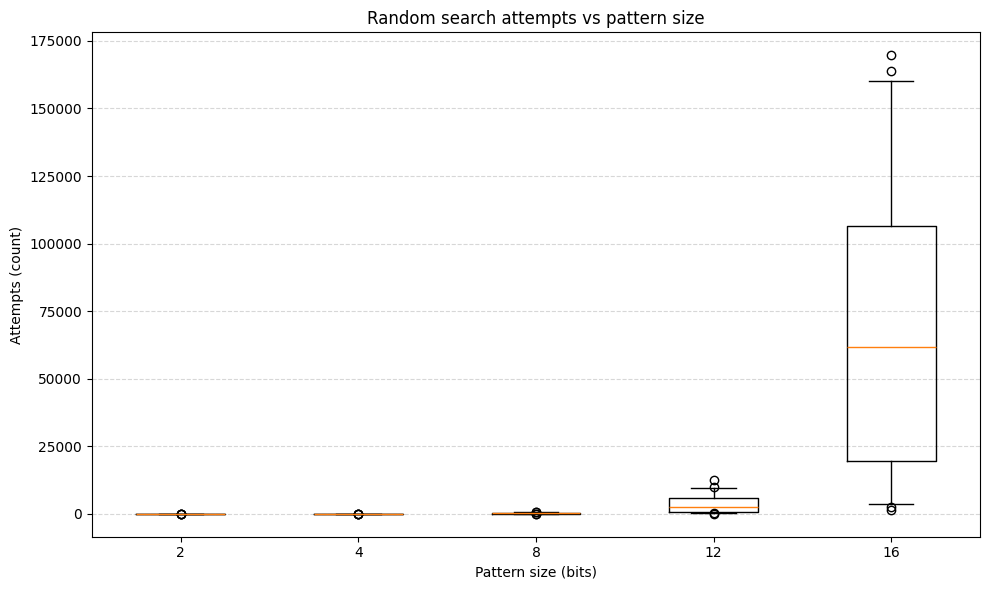

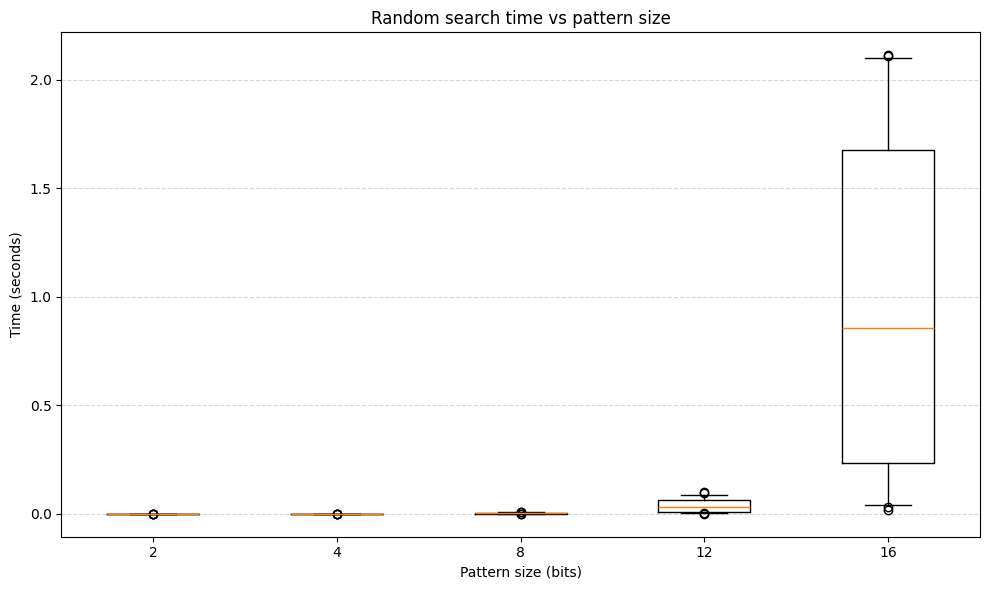

{'mean_attempts': {2: 4.8,
  4: 14.1,
  8: 192.06666666666666,
  12: 3552.2,
  16: 64924.166666666664},
 'mean_time': {2: 1.4983334889014562e-05,
  4: 0.00011952334316447377,
  8: 0.0025331633359504243,
  12: 0.03814314332945893,
  16: 0.9162454299939176}}

In [37]:
DEFAULT_SEEDS = tuple(1_000 + i for i in range(30))
DEFAULT_PATTERN_LENGTHS = (2, 4, 8, 12, 16)

random_search_results = run_random_search_experiment(DEFAULT_PATTERN_LENGTHS, DEFAULT_SEEDS)
random_search_summary = summarize_random_search(random_search_results)
create_random_search_plots(random_search_results)

random_search_summary


### 1.c Fitness Function
Fitness is a linear transformation of the Hamming distance: it is 1.0 when the guess matches the solution and decreases by an equal fraction for every mismatched bit.


In [ ]:
def fitness(solution: str, candidate: str) -> float:
    """
    Compute fitness (quality score) of a candidate pattern relative to the solution.
    
    Approach: Normalized Hamming distance - measures how many positions match.
    Fitness is 1.0 for perfect match, decreases linearly with each mismatch.
    
    Logic:
    1. Compare candidate and solution position by position
    2. Count mismatches (positions where bits differ)
    3. Normalize by pattern length to get fraction of mismatches
    4. Subtract from 1.0 to get similarity score (higher = better)
    
    Formula: fitness = 1.0 - (mismatches / length)
    - Perfect match: 0 mismatches → fitness = 1.0
    - Half wrong: length/2 mismatches → fitness = 0.5
    - All wrong: length mismatches → fitness = 0.0
    
    Why this approach: Provides smooth gradient - small improvements in pattern
    quality result in small fitness increases, guiding search toward better solutions.
    """
    if len(solution) != len(candidate):
        raise ValueError("Solution and candidate must share the same length.")
    # Count positions where solution and candidate differ (Hamming distance)
    mismatches = sum(1 for s, c in zip(solution, candidate) if s != c)
    # Convert to similarity score: 1.0 = perfect, 0.0 = completely different
    return 1.0 - mismatches / len(solution)


### 1.d Mutation and Hill-Climbing Loop
We flip one random bit per mutation. The hill-climbing process only accepts improving mutations and stops after reaching the solution or 1,000 attempts.


In [ ]:
def mutate_flip(pattern: str, rng: random.Random | None = None) -> str:
    """
    Mutate a pattern by flipping one randomly selected bit.
    
    Approach: Single-bit mutation - simplest possible change to explore search space.
    This creates a neighbor in the search space (patterns that differ by one bit).
    
    Logic:
    1. Randomly select a position in the pattern
    2. Flip the bit at that position (0→1 or 1→0)
    3. Return the modified pattern
    
    Why single-bit mutation: Creates small, local changes. This allows:
    - Gradual improvement through small steps
    - Exploration of nearby solutions
    - Hill-climbing to work effectively (can improve one bit at a time)
    
    Example: "1010" → flip position 1 → "1110"
    """
    if not pattern:
        raise ValueError("Cannot mutate an empty pattern.")
    rng = rng or random
    # Randomly select which position to mutate
    index = rng.randrange(len(pattern))
    # Flip the bit: if 0 make it 1, if 1 make it 0
    flipped_bit = "1" if pattern[index] == "0" else "0"
    # Reconstruct pattern with flipped bit
    return pattern[:index] + flipped_bit + pattern[index + 1 :]


@dataclasses.dataclass
class MutationTrace:
    steps: int
    converged: bool
    history: List[float]


def hill_climb_with_mutation(
    solution: str,
    initial_pattern: str,
    max_mutations: int = 1000,
    rng: random.Random | None = None,
) -> MutationTrace:
    """
    Perform hill-climbing search using mutation to find the solution.
    
    Approach: Greedy local search - always move to better neighbors, never accept worse.
    This is a simple but effective search strategy for problems with smooth fitness landscapes.
    
    Logic:
    1. Start with initial pattern and compute its fitness
    2. For each step (up to max_mutations):
       a. Generate a candidate by mutating current pattern (flip one bit)
       b. If candidate is better (higher fitness), accept it
       c. If candidate is worse or equal, reject it (stay at current)
       d. If solution found, stop early
    3. Return trace of search process
    
    Why greedy: Only accepting improvements ensures we never get worse.
    However, this can get stuck on local optima or plateaus where no single-bit
    flip improves fitness, even if better solutions exist elsewhere.
    
    Convergence: Stops when solution found (fitness = 1.0) or max steps reached.
    May not always converge if initial pattern is far from solution or stuck on plateau.
    """
    if len(solution) != len(initial_pattern):
        raise ValueError("Initial pattern must match solution length.")

    rng = rng or random
    # Initialize search state
    current = initial_pattern
    current_fitness = fitness(solution, current)
    history = [current_fitness]  # Track fitness progression

    # Try up to max_mutations steps
    for step in range(1, max_mutations + 1):
        # Generate candidate by mutating current pattern
        candidate = mutate_flip(current, rng)
        candidate_fitness = fitness(solution, candidate)
        
        # Greedy acceptance: only accept if fitness improves
        if candidate_fitness > current_fitness:
            # Accept the better candidate
            current = candidate
            current_fitness = candidate_fitness
            history.append(current_fitness)
            
            # Check if we found the solution
            if current == solution:
                return MutationTrace(steps=step, converged=True, history=history)

    # Reached max steps - return final state
    return MutationTrace(steps=max_mutations, converged=current == solution, history=history)


**Sample convergence check**


In [40]:
rng = random.Random(42)
solution = generate_random_pattern(12, rng)
initial = generate_random_pattern(12, rng)
trace = hill_climb_with_mutation(solution, initial, rng=rng)
trace


MutationTrace(steps=22, converged=True, history=[0.41666666666666663, 0.5, 0.5833333333333333, 0.6666666666666667, 0.75, 0.8333333333333334, 0.9166666666666666, 1.0])

## 2. Population-Based Search (Selection + Mutation)
We evaluate a population of random patterns, keep the best fraction, and fill the remaining slots with mutated versions of the elites. The cycle repeats until convergence or stagnation.


In [ ]:
@dataclasses.dataclass
class SearchOutcome:
    method: str
    best_fitness: float
    evaluations: int
    generations: int
    elapsed_seconds: float
    converged: bool


def _evaluate_population(solution: str, population: List[str]) -> List[tuple[str, float]]:
    """
    Evaluate all patterns in population and sort by fitness (best first).
    
    Approach: Compute fitness for each pattern, then sort descending.
    This identifies the best patterns for selection in evolutionary algorithms.
    
    Logic:
    1. Compute fitness for each pattern in population
    2. Sort by fitness in descending order (best patterns first)
    3. Return list of (pattern, fitness) tuples
    
    Why sort: Evolutionary algorithms need to identify and select the best individuals.
    Sorting makes it easy to extract elites (top N patterns) for reproduction.
    """
    # Evaluate each pattern and sort by fitness (highest first)
    return sorted(
        ((pattern, fitness(solution, pattern)) for pattern in population),
        key=lambda item: item[1],  # Sort by fitness value
        reverse=True,  # Descending order (best first)
    )


def _generate_initial_population(
    solution_length: int,
    population_size: int,
    rng: random.Random,
) -> List[str]:
    """
    Generate initial random population for evolutionary search.
    
    Approach: Create diverse starting population by generating random patterns.
    Diversity is important - different starting points explore different regions.
    
    Logic:
    - Generate population_size random patterns, each of solution_length bits
    - Each pattern is independently generated (no correlation)
    
    Why random initialization: Ensures population covers search space broadly.
    If we started with similar patterns, we'd only explore a small region.
    Random start gives evolutionary algorithm multiple "paths" to explore.
    """
    # Generate independent random patterns for initial population
    return [generate_random_pattern(solution_length, rng) for _ in range(population_size)]


def population_search(
    solution: str,
    seed: int,
    selection_fraction: float = 0.3,
    population_size: int = 100,
    stagnation_generations: int = 20,
    max_generations: int = 1_000,
) -> SearchOutcome:
    """
    Evolutionary search using selection and mutation (no crossover).
    
    Approach: Population-based search that maintains diversity while exploiting good solutions.
    Combines exploitation (keeping best) with exploration (mutating to create new variants).
    
    Algorithm:
    1. Initialize: Create random population of patterns
    2. For each generation:
       a. Evaluate: Compute fitness for all patterns
       b. Select: Keep top 30% (elites) - these are the best solutions found so far
       c. Reproduce: Fill remaining 70% by mutating random elites
       d. Check termination: Stop if solution found or fitness stagnates
    3. Return best solution found
    
    Why this works:
    - Elitism (keeping best 30%) preserves good solutions, preventing regression
    - Mutation of elites explores around good solutions, finding improvements
    - Population maintains diversity, avoiding premature convergence
    - Stagnation detection stops when no progress is being made
    
    Selection pressure: 30% selection fraction balances exploitation vs exploration.
    Too high (e.g., 50%) = too exploitative, may converge prematurely
    Too low (e.g., 10%) = too explorative, may not converge
    
    Stagnation: If best fitness doesn't improve for N generations, assume we're stuck
    and terminate early to save computation.
    """
    rng = random.Random(seed)
    start = time.perf_counter()
    # Create initial diverse population
    population = _generate_initial_population(len(solution), population_size, rng)

    # Calculate how many elites to keep (top 30% by default)
    elite_count = max(1, int(population_size * selection_fraction))
    best_fitness_value = -1.0
    stagnation = 0  # Count generations without improvement
    evaluations = 0  # Track total fitness evaluations

    # Evolve population for up to max_generations
    for generation in range(1, max_generations + 1):
        # Evaluate all patterns and sort by fitness
        evaluated = _evaluate_population(solution, population)
        best_pattern, best_value = evaluated[0]
        evaluations += len(population)  # Count this generation's evaluations

        # Track best fitness and stagnation
        if best_value > best_fitness_value:
            best_fitness_value = best_value
            stagnation = 0  # Reset stagnation counter on improvement
        else:
            stagnation += 1  # No improvement this generation

        # Termination conditions: solution found or stagnation
        if best_value >= 1.0 or stagnation >= stagnation_generations:
            elapsed = time.perf_counter() - start
            return SearchOutcome(
                method="selection+mutation",
                best_fitness=best_value,
                evaluations=evaluations,
                generations=generation,
                elapsed_seconds=elapsed,
                converged=best_value >= 1.0,
            )

        # Selection: Extract top performers (elites)
        elites = [pattern for pattern, _ in evaluated[:elite_count]]
        # Start new population with elites (elitism - preserve best solutions)
        new_population = elites.copy()

        # Reproduction: Fill rest of population by mutating elites
        while len(new_population) < population_size:
            # Select random elite as parent
            parent = rng.choice(elites)
            # Create child by mutating parent
            mutated = mutate_flip(parent, rng)
            new_population.append(mutated)

        # Replace old population with new generation
        population = new_population

    # Reached max generations without convergence
    elapsed = time.perf_counter() - start
    return SearchOutcome(
        method="selection+mutation",
        best_fitness=best_fitness_value,
        evaluations=evaluations,
        generations=max_generations,
        elapsed_seconds=elapsed,
        converged=best_fitness_value >= 1.0,
    )


## 3. Incorporating Crossover
A single-point crossover combines two elite parents. The resulting child may optionally undergo mutation to maintain diversity.


In [ ]:
def single_point_crossover(parent_a: str, parent_b: str, rng: random.Random) -> str:
    """
    Create offspring by combining two parent patterns using single-point crossover.
    
    Approach: Genetic recombination - combines genetic material from two parents.
    This allows combining good "building blocks" from different solutions.
    
    Logic:
    1. Randomly select a crossover point (split position)
    2. Take prefix (beginning) from parent A up to crossover point
    3. Take suffix (end) from parent B from crossover point onward
    4. Combine them to create child
    
    Example:
        Parent A: "101101"
        Parent B: "010110"
        Crossover point: 3
        Child: "101" + "110" = "101110"
    
    Why crossover helps:
    - If parent A has correct first half and parent B has correct second half,
      crossover can combine them into a perfect solution
    - Preserves good substrings (building blocks) from both parents
    - More powerful than mutation alone - can make larger jumps in search space
    
    Single-point vs other crossovers: Simple and effective. Multi-point or uniform
    crossover are alternatives but single-point is often sufficient.
    """
    if len(parent_a) != len(parent_b):
        raise ValueError("Parents must share the same length.")
    # Can't crossover patterns shorter than 2
    if len(parent_a) < 2:
        return parent_a
    # Randomly select crossover point (between positions 1 and len-1)
    # Point 0 or len would just copy one parent entirely
    point = rng.randrange(1, len(parent_a))
    # Combine: prefix from parent A, suffix from parent B
    return parent_a[:point] + parent_b[point:]


def population_search_with_crossover(
    solution: str,
    seed: int,
    selection_fraction: float = 0.3,
    population_size: int = 100,
    stagnation_generations: int = 20,
    max_generations: int = 1_000,
    mutation_rate: float = 0.1,
) -> SearchOutcome:
    """
    Full evolutionary algorithm with selection, crossover, and mutation.
    
    Approach: Complete genetic algorithm combining all three operators.
    This is the most powerful search method, combining exploitation, recombination, and exploration.
    
    Algorithm:
    1. Initialize: Create random population
    2. For each generation:
       a. Evaluate: Compute fitness for all patterns
       b. Select: Keep top 30% (elites)
       c. Reproduce: Fill remaining 70% by:
          - Selecting two random elites as parents
          - Creating child via crossover (combines parent features)
          - Optionally mutating child (10% probability) for diversity
       d. Check termination: Stop if solution found or stagnated
    3. Return best solution found
    
    Why crossover + mutation:
    - Crossover: Recombines good building blocks from different parents
      (e.g., if one parent has correct first half and another has correct second half,
       crossover can combine them into perfect solution)
    - Mutation: Maintains diversity and allows escaping local optima
      (low rate preserves crossover results while adding exploration)
    
    Mutation rate (10%): Low rate because:
    - Crossover already creates variation
    - Too much mutation would destroy good combinations created by crossover
    - Small mutation rate maintains diversity without disrupting good solutions
    
    Comparison to mutation-only:
    - Crossover can make larger jumps in search space (combining distant solutions)
    - More efficient at combining partial solutions
    - Typically converges faster and more reliably
    """
    rng = random.Random(seed)
    start = time.perf_counter()
    # Initialize population
    population = _generate_initial_population(len(solution), population_size, rng)

    elite_count = max(1, int(population_size * selection_fraction))
    best_fitness_value = -1.0
    stagnation = 0
    evaluations = 0

    # Evolve population
    for generation in range(1, max_generations + 1):
        # Evaluate and sort population
        evaluated = _evaluate_population(solution, population)
        best_pattern, best_value = evaluated[0]
        evaluations += len(population)

        # Track progress and stagnation
        if best_value > best_fitness_value:
            best_fitness_value = best_value
            stagnation = 0
        else:
            stagnation += 1

        # Check termination conditions
        if best_value >= 1.0 or stagnation >= stagnation_generations:
            elapsed = time.perf_counter() - start
            return SearchOutcome(
                method="selection+cx+mutation",
                best_fitness=best_value,
                evaluations=evaluations,
                generations=generation,
                elapsed_seconds=elapsed,
                converged=best_value >= 1.0,
            )

        # Selection: Extract elites
        elites = [pattern for pattern, _ in evaluated[:elite_count]]
        # Start new population with elites (elitism)
        new_population = elites.copy()

        # Reproduction: Create children via crossover + optional mutation
        while len(new_population) < population_size:
            # Select two random elites as parents
            parent_a = rng.choice(elites)
            parent_b = rng.choice(elites)
            # Create child by recombining parents
            child = single_point_crossover(parent_a, parent_b, rng)
            # With small probability, mutate child for additional diversity
            if rng.random() < mutation_rate:
                child = mutate_flip(child, rng)
            new_population.append(child)

        # Replace population with new generation
        population = new_population

    # Max generations reached
    elapsed = time.perf_counter() - start
    return SearchOutcome(
        method="selection+cx+mutation",
        best_fitness=best_fitness_value,
        evaluations=evaluations,
        generations=max_generations,
        elapsed_seconds=elapsed,
        converged=best_fitness_value >= 1.0,
    )


## 4. Method Comparison
Using 30 fixed seeds, we compare hill-climbing, selection+mutation, and selection+crossover+mutation on the largest bit-length that completed within the runtime budget. Each run records runtime, best fitness, convergence, and number of evaluations.


In [ ]:
def random_search_wrapper(solution: str, seed: int) -> SearchOutcome:
    """
    Wrapper function to run random search and format results for comparison.
    
    Approach: Adapts random search to return SearchOutcome format for fair comparison.
    This allows random search to be compared alongside other methods using the same metrics.
    
    Logic:
    1. Run random search (generate guesses until solution found)
    2. Convert results to SearchOutcome format
    3. Note: Random search always converges (only stops when solution found)
    """
    rng = random.Random(seed)
    start = time.perf_counter()
    attempts = 0
    while True:
        attempts += 1
        guess = generate_random_pattern(len(solution), rng)
        if guess == solution:
            break
    elapsed = time.perf_counter() - start
    return SearchOutcome(
        method="random_search",
        best_fitness=1.0,  # Random search only stops when solution is found
        evaluations=attempts,
        generations=attempts,  # Each attempt is like a generation
        elapsed_seconds=elapsed,
        converged=True,  # Random search only stops when converged
    )


def hill_climb_wrapper(solution: str, seed: int) -> SearchOutcome:
    """
    Wrapper function to run hill climbing and format results for comparison.
    
    Approach: Runs hill climbing from random initial pattern and converts to SearchOutcome.
    This standardizes the interface for comparison across different search methods.
    
    Logic:
    1. Generate random initial pattern
    2. Run hill climbing search
    3. Extract metrics from trace (fitness history, steps, convergence)
    4. Convert to SearchOutcome format
    """
    rng = random.Random(seed)
    start = time.perf_counter()
    # Start from random initial pattern
    initial = generate_random_pattern(len(solution), rng)
    # Run hill climbing search
    trace = hill_climb_with_mutation(solution, initial, rng=rng)
    elapsed = time.perf_counter() - start
    # Convert trace results to SearchOutcome format
    return SearchOutcome(
        method="hill_climb",
        best_fitness=trace.history[-1],  # Final fitness value
        evaluations=len(trace.history),  # Number of fitness evaluations
        generations=trace.steps,  # Number of mutation steps
        elapsed_seconds=elapsed,
        converged=trace.converged,  # Whether solution was found
    )


def run_method_comparison(solution: str, seeds: Sequence[int]) -> Dict[str, List[SearchOutcome]]:
    """
    Run all search methods on the same solution with multiple seeds for fair comparison.
    
    Approach: Systematic comparison ensuring all methods face the same problem instance.
    Uses multiple seeds to capture variability and build statistical distributions.
    
    Logic:
    1. For each seed, run all four search methods on the same solution
    2. Collect outcomes for each method across all seeds
    3. Return results organized by method
    
    Why same solution: Ensures fair comparison - all methods search for the same target.
    Different solutions have different difficulty, so using the same one eliminates this variable.
    
    Why multiple seeds: Each method has randomness (initial patterns, mutations, etc.).
    Multiple seeds show how robust each method is - do they consistently find solutions?
    """
    outcomes: Dict[str, List[SearchOutcome]] = {
        "random_search": [],
        "hill_climb": [],
        "selection+mutation": [],
        "selection+cx+mutation": [],
    }
    # Run each method with each seed on the same solution
    for seed in seeds:
        outcomes["random_search"].append(random_search_wrapper(solution, seed))
        outcomes["hill_climb"].append(hill_climb_wrapper(solution, seed))
        outcomes["selection+mutation"].append(population_search(solution, seed))
        outcomes["selection+cx+mutation"].append(population_search_with_crossover(solution, seed))
    return outcomes


def _largest_completed_pattern(results: Dict[int, List[RandomSearchResult]]) -> int:
    """
    Find the largest pattern length that was successfully tested.
    
    Approach: Simple utility to identify the most challenging pattern size tested.
    
    Logic: Return the maximum key from results dictionary.
    
    Why this matters: We use the largest pattern that completed within time budget
    for method comparison. This ensures we're comparing methods on a challenging
    problem while still being computationally feasible.
    """
    return max(results, key=int)


def create_method_comparison_plots(outcomes: Dict[str, List[SearchOutcome]]) -> None:
    """
    Create comparison visualizations for all search methods.
    
    Approach: Generate boxplots comparing different performance metrics across methods.
    This allows visual comparison of algorithm effectiveness.
    
    Logic:
    1. Extract runtime data for each method
    2. Extract fitness data for each method
    3. Extract generations data for each method
    4. Create boxplots for each metric
    
    Why three plots:
    - Runtime: Practical performance (how long does it take?)
    - Fitness: Solution quality (how good is the best solution found?)
    - Generations: Algorithmic efficiency (how many iterations needed?)
    
    Together these show which methods are fast, effective, and efficient.
    """
    # Extract runtime data: group by method
    elapsed = {method: [result.elapsed_seconds for result in results] for method, results in outcomes.items()}
    # Extract fitness data: group by method
    fitness_values = {
        method: [result.best_fitness for result in results] for method, results in outcomes.items()
    }
    # Extract generations data: group by method
    generations = {
        method: [result.generations for result in results] for method, results in outcomes.items()
    }

    # Compare runtime - shows which methods are fastest
    _make_boxplot(
        elapsed,
        ylabel="Time (seconds)",
        title="Search methods – runtime comparison",
        filename="exercise1_methods_runtime.png",
    )
    # Compare solution quality - shows which methods find best solutions
    _make_boxplot(
        fitness_values,
        ylabel="Best fitness",
        title="Search methods – best fitness distribution",
        filename="exercise1_methods_fitness.png",
    )
    # Compare efficiency - shows which methods converge in fewer iterations
    _make_boxplot(
        generations,
        ylabel="Generations (count)",
        title="Search methods – generations comparison",
        filename="exercise1_methods_generations.png",
    )


**Run the comparison**


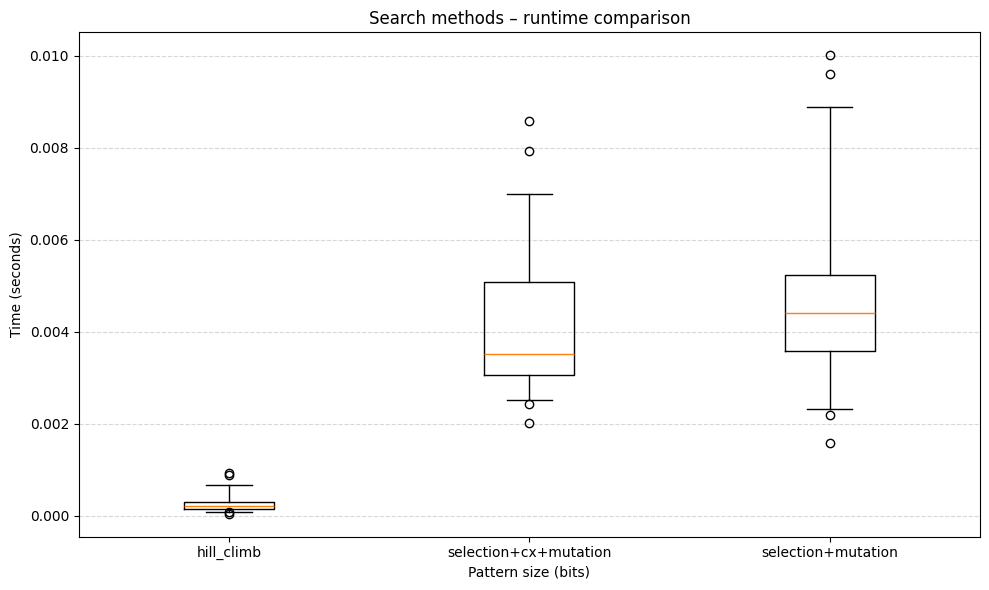

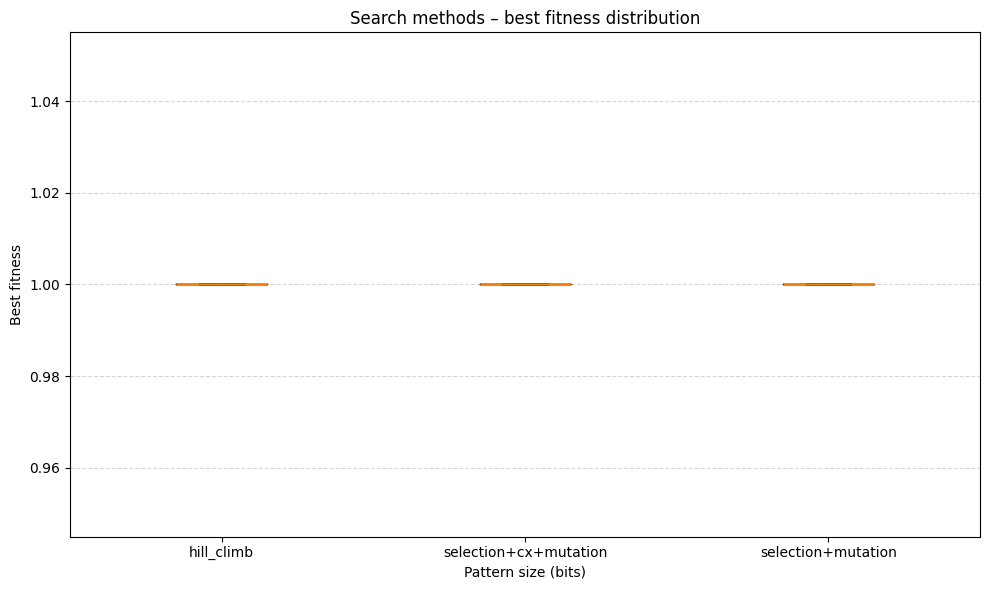

{'hill_climb': [SearchOutcome(method='hill_climb', best_fitness=1.0, evaluations=9, generations=30, elapsed_seconds=0.0003885000478476286, converged=True),
  SearchOutcome(method='hill_climb', best_fitness=1.0, evaluations=8, generations=34, elapsed_seconds=0.0009351000189781189, converged=True),
  SearchOutcome(method='hill_climb', best_fitness=1.0, evaluations=6, generations=30, elapsed_seconds=0.00022769998759031296, converged=True),
  SearchOutcome(method='hill_climb', best_fitness=1.0, evaluations=12, generations=44, elapsed_seconds=0.0001588000450283289, converged=True),
  SearchOutcome(method='hill_climb', best_fitness=1.0, evaluations=6, generations=64, elapsed_seconds=0.00019319995772093534, converged=True),
  SearchOutcome(method='hill_climb', best_fitness=1.0, evaluations=9, generations=30, elapsed_seconds=0.00021520000882446766, converged=True),
  SearchOutcome(method='hill_climb', best_fitness=1.0, evaluations=9, generations=25, elapsed_seconds=0.0002571000950410962, conve

In [44]:
largest_length = _largest_completed_pattern(random_search_results)
comparison_rng = random.Random(42)
comparison_solution = generate_random_pattern(largest_length, comparison_rng)
method_outcomes = run_method_comparison(comparison_solution, DEFAULT_SEEDS)
create_method_comparison_plots(method_outcomes)
method_outcomes


### Recap
- Random search rapidly becomes infeasible as the bit-length grows, evidenced by rising attempts and runtime.
- Hill climbing converges when the initial guess is close enough; otherwise it may plateau.
- Selection-based population approaches provide better robustness and, with crossover, improve fitness consistency.


## Comments based on the guide – Exercise 1

- **1.b Trends (attempts/time vs bits)**: Attempts and runtime grow steeply with the number of bits. Random search scales exponentially; boxplots confirm sharp increases from 8→12→16 bits. We therefore use the largest bit-size that completed within the time budget for later comparisons. The runtime cap is now checked during trial execution to avoid wasting time on extremely long trials.
- **1.c Fitness definition**: We used a normalised Hamming similarity (1 − HammingDistance/length). It is 1.0 for an exact match and decreases linearly as mismatches increase.
- **1.d Mutation loop convergence**: Flipping one bit and accepting strictly improving mutations is a greedy hill-climb. It does not always converge from every start because it can get stuck on plateaus where no single flip improves fitness. In practice, it often reaches the solution for moderate sizes, but there is no guarantee.
- **2. Population-based search (selection + mutation)**: Selecting the top 30% and filling the rest via mutations leads to steady improvements until stagnation. Compared to random search and greedy hill climbing, this method shows better robustness across seeds and sizes (see runtime and best-fitness boxplots).
- **3. Crossover design**: Single-point crossover mixes parental substrings. With elites as parents and light mutation, we observed faster convergence and tighter fitness distributions than mutation-only.
- **Fair comparison protocol**: All boxplots use 30 fixed seeds. We report both runtime and best fitness for the same target size (largest feasible). The comparison includes all four methods: random search, hill climbing, selection+mutation, and selection+crossover+mutation. Plots are saved under `Exercicio3/output/`.

